## Bukit Purmei 2022

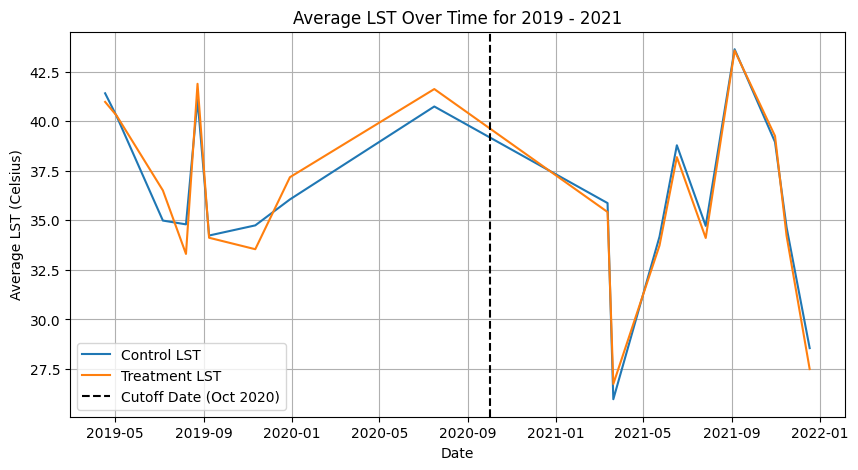

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Paths to the CSV files
file_path1 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\BukitPurmei\Landsat8\BukitPurmei_Filtered_2019_to_2021_Blocks.csv"
file_path2 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\BukitPurmei\Landsat7\BukitPurmei_Filtered_2019_to_2021_Blocks.csv"
file_path3 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\BukitPurmei\Landsat9\BukitPurmei_Filtered_2021_Blocks.csv"

# Read the CSV files
df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)
df3 = pd.read_csv(file_path3)

# Rename temperature columns to a unified column name
df1.rename(columns={'ST_B10_Celsius': 'LST_Celsius'}, inplace=True)
df2.rename(columns={'ST_B6_Celsius': 'LST_Celsius'}, inplace=True)
df3.rename(columns={'ST_B10_Celsius' : 'LST_Celsius'}, inplace=True)

# Concatenate the two dataframes
bukit_purmei_2022_df = pd.concat([df1, df2, df3], ignore_index=True)

# # Filter for 'QA_PIXEL' = 21824
# bukit_purmei_2022_df = bukit_purmei_2022_df[bukit_purmei_2022_df['QA_PIXEL'] == 21824]

# Convert 'time' to datetime and filter for the year 2022
bukit_purmei_2022_df['time'] = pd.to_datetime(bukit_purmei_2022_df['time'])
# bukit_purmei_2022_df = bukit_purmei_2022_df[bukit_purmei_2022_df['time'].dt.date >= pd.to_datetime('2019-01-01').date()]

# Filter out unwanted QA_PIXEL values
qa_pixel_filter = [54596, 21952, 22280, 55052, 23888, 24144, 24082, 56660, 23826, 5896, 7698, 7442, 7440]
bukit_purmei_2022_df = bukit_purmei_2022_df[~bukit_purmei_2022_df['QA_PIXEL'].isin(qa_pixel_filter)]

# Additional filtering for 'SR_QA_AEROSOL'
sr_qa_aerosol_filter = [192, 194, 196, 224, 228]
bukit_purmei_2022_df = bukit_purmei_2022_df[~bukit_purmei_2022_df['SR_QA_AEROSOL'].isin(sr_qa_aerosol_filter)]

# Map blocks to grouped blocks
block_group_map = {
    'polygon_112': 'Treatment',
    'polygon_114': 'Treatment',
    'polygon_113': 'Control',
    'polygon_115': 'Control'
}
bukit_purmei_2022_df['group'] = bukit_purmei_2022_df['block'].map(block_group_map)

# Group by 'group' and 'time', and calculate the average ST_B10_Celsius
grouped_data = bukit_purmei_2022_df.groupby(['group', bukit_purmei_2022_df['time'].dt.date])['LST_Celsius'].mean().unstack(0)
grouped_data = grouped_data.dropna(how='any', axis=0)

# Plotting
plt.figure(figsize=(10, 5))
cutoff_date = pd.to_datetime('2020-10-01')
for column in grouped_data.columns:
    plt.plot(grouped_data.index, grouped_data[column], label=f'{column} LST')
    # plt.scatter(grouped_data.index, grouped_data[column], color='red')  # Dots on each data point

# Add the cutoff date line once outside the loop
plt.axvline(x=cutoff_date, color='black', linestyle='--', label='Cutoff Date (Oct 2020)')  # Vertical line at the cutoff date
plt.title('Average LST Over Time for 2019 - 2021')
plt.xlabel('Date')
plt.ylabel('Average LST (Celsius)')
plt.grid(True)
plt.legend()
plt.show()

### Difference-in-Difference Test

In [ ]:
# For treatment, create a variable `treatment` where its values are `1` for polygon_112 and polygon_114 
# and `0` for polygon_113 and polygon_115

# For time, create a variable `time` where its values are `1` for time period >= October 2020
# and `0` for dates < October 2020

# Interaction term is both multiplied with each other, estimate the effects

import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Assuming 'bukit_purmei_2022_df' is already loaded
# Convert 'time' column to datetime if it's not already
bukit_purmei_2022_df['time'] = pd.to_datetime(bukit_purmei_2022_df['time'])

# Create 'treatment' column where 'Treatment' group members receive 1, others 0
bukit_purmei_2022_df['treatment'] = (bukit_purmei_2022_df['group'] == 'Treatment').astype(int)

# Create 'time' column for post-treatment period (October 2020 onwards), assigning 1 for post-treatment and 0 otherwise
cutoff_date = pd.Timestamp('2020-10-01')
bukit_purmei_2022_df['treatment_date'] = (bukit_purmei_2022_df['time'].dt.date >= cutoff_date.date()).astype(int)

# Define the formula for the regression model including the interaction term directly
formula = 'LST_Celsius ~ treatment + treatment_date + treatment:treatment_date'

# Fit the DiD regression model using ordinary least squares (OLS)
model = smf.ols(formula, data=bukit_purmei_2022_df).fit()

# Print the results
print(model.summary())

Index(['Longitude', 'Latitude', 'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5',
       'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST',
       'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD',
       'QA_PIXEL', 'QA_RADSAT', 'LST_Celsius', 'SR_B1_Scaled', 'SR_B2_Scaled',
       'SR_B3_Scaled', 'SR_B4_Scaled', 'SR_B5_Scaled', 'SR_B6_Scaled',
       'SR_B7_Scaled', 'ST_ATRAN_Scaled', 'ST_CDIST_Scaled', 'ST_DRAD_Scaled',
       'ST_EMIS_Scaled', 'ST_EMSD_Scaled', 'ST_QA_Scaled', 'ST_TRAD_Scaled',
       'ST_URAD_Scaled', 'time', 'block', 'SR_ATMOS_OPACITY', 'SR_CLOUD_QA',
       'ST_B6', 'group'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:            LST_Celsius   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     29.54
Date:                Tue, 11 

#### Prior Trends Test (Parallel Trends Assumption)

In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

df = bukit_purmei_2022_df

# Define the cutoff date
cutoff_date = pd.Timestamp('2020-10-01')

# Filter the dataset to include only data before the cutoff date
df_pre = df[df['time'] < cutoff_date].copy()

# Create the time variable as the number of periods from the start of the data
df_pre['time_periods'] = pd.factorize(df_pre['time'].dt.date)[0]

# Create interaction term for Time * Group
df_pre['int_time_group'] = df_pre['time_periods'] * df_pre['group'].map({'Treatment': 1, 'Control': 0})

# Fit the regression model
model = smf.ols('LST_Celsius ~ time_periods + int_time_group + C(group)', data=df_pre).fit()

# Print the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            LST_Celsius   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     28.51
Date:                Tue, 11 Jun 2024   Prob (F-statistic):           6.97e-16
Time:                        15:32:59   Log-Likelihood:                -636.82
No. Observations:                 253   AIC:                             1282.
Df Residuals:                     249   BIC:                             1296.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                41.44

#### Placebo Test

##### Chosen fake treatment dates are 2019-09, 2019-12, 2020-03, 2020-06. All show that there is insufficient evidence to prove that the estimate is not equal to 0

In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Assuming 'bukit_purmei_2022_df' is already loaded
# Ensure the 'time' column is in datetime format
bukit_purmei_2022_df['time'] = pd.to_datetime(bukit_purmei_2022_df['time'])

# Filter data before October 2020 to simulate the pre-treatment period
pre_treatment_cutoff = pd.Timestamp('2020-10-01')
df_pre_treatment = bukit_purmei_2022_df[bukit_purmei_2022_df['time'] < pre_treatment_cutoff].copy()

# Create a 'treatment' column where 'Treatment' group members receive 1, others 0
df_pre_treatment['treatment'] = (df_pre_treatment['group'].isin(['Treatment'])).astype(int)

# Create a 'time' column for the fake treatment period, setting the fake treatment date to September 1, 2020
fake_treatment_date = pd.Timestamp('2019-09-01')
df_pre_treatment['treatment_date'] = (df_pre_treatment['time'].dt.date >= fake_treatment_date.date()).astype(int)

# Interaction term combining treatment and treatment_date
df_pre_treatment['treatment_treatment_date'] = df_pre_treatment['treatment'] * df_pre_treatment['treatment_date']

# Define the formula for the regression model including the interaction term directly
formula = 'LST_Celsius ~ treatment + treatment_date + treatment_treatment_date'

# Fit the DiD regression model using ordinary least squares (OLS)
model = smf.ols(formula, data=df_pre_treatment).fit()

# Print the results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            LST_Celsius   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     27.82
Date:                Tue, 11 Jun 2024   Prob (F-statistic):           1.49e-15
Time:                        17:04:26   Log-Likelihood:                -637.60
No. Observations:                 253   AIC:                             1283.
Df Residuals:                     249   BIC:                             1297.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Assuming 'bukit_purmei_2022_df' is already loaded
# Ensure the 'time' column is in datetime format
bukit_purmei_2022_df['time'] = pd.to_datetime(bukit_purmei_2022_df['time'])

# Filter data before October 2020 to simulate the pre-treatment period
pre_treatment_cutoff = pd.Timestamp('2020-10-01')
df_pre_treatment = bukit_purmei_2022_df[bukit_purmei_2022_df['time'] < pre_treatment_cutoff].copy()

# Create a 'treatment' column where 'Treatment' group members receive 1, others 0
df_pre_treatment['treatment'] = (df_pre_treatment['group'].isin(['Treatment'])).astype(int)

# Create a 'time' column for the fake treatment period, setting the fake treatment date to September 1, 2020
fake_treatment_date = pd.Timestamp('2019-12-01')
df_pre_treatment['treatment_date'] = (df_pre_treatment['time'].dt.date >= fake_treatment_date.date()).astype(int)

# Interaction term combining treatment and treatment_date
df_pre_treatment['treatment_treatment_date'] = df_pre_treatment['treatment'] * df_pre_treatment['treatment_date']

# Define the formula for the regression model including the interaction term directly
formula = 'LST_Celsius ~ treatment + treatment_date + treatment_treatment_date'

# Fit the DiD regression model using ordinary least squares (OLS)
model = smf.ols(formula, data=df_pre_treatment).fit()

# Print the results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            LST_Celsius   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9093
Date:                Tue, 11 Jun 2024   Prob (F-statistic):              0.437
Time:                        17:04:37   Log-Likelihood:                -672.79
No. Observations:                 253   AIC:                             1354.
Df Residuals:                     249   BIC:                             1368.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Assuming 'bukit_purmei_2022_df' is already loaded
# Ensure the 'time' column is in datetime format
bukit_purmei_2022_df['time'] = pd.to_datetime(bukit_purmei_2022_df['time'])

# Filter data before October 2020 to simulate the pre-treatment period
pre_treatment_cutoff = pd.Timestamp('2020-10-01')
df_pre_treatment = bukit_purmei_2022_df[bukit_purmei_2022_df['time'] < pre_treatment_cutoff].copy()

# Create a 'treatment' column where 'Treatment' group members receive 1, others 0
df_pre_treatment['treatment'] = (df_pre_treatment['group'].isin(['Treatment'])).astype(int)

# Create a 'time' column for the fake treatment period, setting the fake treatment date to September 1, 2020
fake_treatment_date = pd.Timestamp('2020-03-01')
df_pre_treatment['treatment_date'] = (df_pre_treatment['time'].dt.date >= fake_treatment_date.date()).astype(int)

# Interaction term combining treatment and treatment_date
df_pre_treatment['treatment_treatment_date'] = df_pre_treatment['treatment'] * df_pre_treatment['treatment_date']

# Define the formula for the regression model including the interaction term directly
formula = 'LST_Celsius ~ treatment + treatment_date + treatment_treatment_date'

# Fit the DiD regression model using ordinary least squares (OLS)
model = smf.ols(formula, data=df_pre_treatment).fit()

# Print the results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            LST_Celsius   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     3.896
Date:                Tue, 11 Jun 2024   Prob (F-statistic):            0.00954
Time:                        17:05:02   Log-Likelihood:                -668.37
No. Observations:                 253   AIC:                             1345.
Df Residuals:                     249   BIC:                             1359.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Assuming 'bukit_purmei_2022_df' is already loaded
# Ensure the 'time' column is in datetime format
bukit_purmei_2022_df['time'] = pd.to_datetime(bukit_purmei_2022_df['time'])

# Filter data before October 2020 to simulate the pre-treatment period
pre_treatment_cutoff = pd.Timestamp('2020-10-01')
df_pre_treatment = bukit_purmei_2022_df[bukit_purmei_2022_df['time'] < pre_treatment_cutoff].copy()

# Create a 'treatment' column where 'Treatment' group members receive 1, others 0
df_pre_treatment['treatment'] = (df_pre_treatment['group'].isin(['Treatment'])).astype(int)

# Create a 'time' column for the fake treatment period, setting the fake treatment date to September 1, 2020
fake_treatment_date = pd.Timestamp('2020-06-01')
df_pre_treatment['treatment_date'] = (df_pre_treatment['time'].dt.date >= fake_treatment_date.date()).astype(int)

# Interaction term combining treatment and treatment_date
df_pre_treatment['treatment_treatment_date'] = df_pre_treatment['treatment'] * df_pre_treatment['treatment_date']

# Define the formula for the regression model including the interaction term directly
formula = 'LST_Celsius ~ treatment + treatment_date + treatment_treatment_date'

# Fit the DiD regression model using ordinary least squares (OLS)
model = smf.ols(formula, data=df_pre_treatment).fit()

# Print the results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            LST_Celsius   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     3.896
Date:                Tue, 11 Jun 2024   Prob (F-statistic):            0.00954
Time:                        17:05:14   Log-Likelihood:                -668.37
No. Observations:                 253   AIC:                             1345.
Df Residuals:                     249   BIC:                             1359.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               